# Домашнее задание №1. Softmax Regression.

---



Нужно реализовать много-классовую логистическую регрессию с помощью softmax c поддержкой L1/L2 регуляризации. Для реализации использовать numpy библиотеку. После этого сравнить с sklearn реализацией [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 с настройкой **multinomial**.

In [556]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## Задание №1 (10 баллов)

Реализовать класс SoftMaxRegression и его методы - init, fit, predict c возможностью конфигурации
регуляризации. 
Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**. 

Остальные функции реализовать на ваше усмотрение. 

In [897]:
class SoftMaxRegression:
    def __init__(self, regularization_type: float, lmbd: float=1e-3, max_iter: int=10000, 
                 lr: float=1e-2, batch_size: int=1000):
        """
        regularization_type: float - позволяет варьировать между L1 и L2 регуляризацией (лежит в диапозоне [0;1])
        lmbd: float - коэффициент влияния регуляризации
        max_iter: int - количество итераций
        lr: float - шаг градиентного спуска
        """
        self.regularization_type = regularization_type
        self.lmbd = lmbd
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size

    def softMax(self, z):
        """SoftMax"""
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def loss_function(self, X, y, y_pred):
        """функция подсчёта ошибки"""
        y = self.one_hot(y)
        L1 = (1 - self.regularization_type)*(np.sum(np.abs(self.W)) + np.sum(np.abs(self.b)))
        L2 = self.regularization_type*(np.sum(self.W**2) + np.sum(self.b**2))
        #Loss function с возможностью вариарирования двух видов регуляризации
        Loss = np.sum(-np.log(y_pred)*y) + self.lmbd*(L1 + L2)
        return Loss

    def grad_loss(self, X, y, y_pred):
        """функция подсчёта градиента ошибки"""
        y = self.one_hot(y)
        dL1_dw = (1 - self.regularization_type)*np.sign(self.W)
        dL1_db = (1 - self.regularization_type)*np.sign(self.b)
        dL2_dw = 2*self.regularization_type*self.W
        dL2_db = 2*self.regularization_type*self.b
        #подсчёт частных производных от лосса
        dL_dw = 1/X.shape[0] * np.dot(X.T, (y_pred - y)) + self.lmbd*(dL1_dw + dL2_dw) 
        dL_db = -1/X.shape[0] * np.sum(y - y_pred, axis = 0) + self.lmbd*(dL1_db + dL2_db) 
        return dL_dw, dL_db

    def one_hot(self, y):
        return np.eye(self.count_of_classes)[y.astype(int)]
    
    def fit(self, X_train, y_train, X_val, y_val):
        """функция обучения модели"""
        history_loss_val = []
        history_loss_train = []
        history_accuracy = []
        local_loss_train = []

        self.count_of_classes = len(np.unique(y_train))
        self.W = np.random.normal(0, 1, size=(X_train.shape[-1], self.one_hot(y_train).shape[-1]))
        self.b = np.random.normal(0, 1, self.one_hot(y_train).shape[-1])

        for epoch in tqdm(range(self.max_iter)):
            local_loss_train = []
            for iteration in range(X_train.shape[0] // self.batch_size + 1):
                index_start = iteration*self.batch_size
                index_end = (iteration+1)*self.batch_size
                
                if X_train[index_start:index_end].shape[0] == 0:
                    break
                    
                y_i = y_train[index_start:index_end]
                X_i = X_train[index_start:index_end]
                y_pred_i = self.softMax(X_i @ self.W + self.b)
                loss = self.loss_function(X_i, y_i, y_pred_i)
                grad_W, grad_b = self.grad_loss(X_i, y_i, y_pred_i)
                #update W, b
                self.W -= self.lr*grad_W
                self.b -= self.lr*grad_b
                #write loss
                local_loss_train.append(loss)
            history_accuracy.append(self.accuracy(self.predict(X_val), y_val))
            history_loss_train.append(np.mean(local_loss_train))
            history_loss_val.append(self.loss_function(X_val, y_val, self.softMax(X_val @ self.W + self.b)))
        return history_loss_train, history_loss_val, history_accuracy
    
    def predict(self, X):
        """функция предсказания"""
        return np.argmax(self.softMax(X @ self.W + self.b), axis=-1)

    def accuracy(self, y, y_pred):
        return np.mean(y == y_pred)

## Задание №2 (10 баллов)

Загрузите любой датасет много-классовой классификации, сделайте предобработку, разбейте на тренировочную и тестовую выборку  и оцените работу вашего алгоритма. Предпочтительно использовать метрику точности(accuracy) для оценки алгоритма. 

В рамках оценки, воспользуйтесь sklearn реализацией много-классовой логистической регрессии. **Проверьте что ваши метрики совпадают(+/-1-2%) на моделях без регуляризации, с L1 и с L2 регуляризации.**

#### Работа с датасетом (1 балл)

Загрузите выбранный датасет много-классовой классификации, обработайте его, сделайте разбиение на тренировочную и тестовую выборку. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).

#### Обучение модели и сравнение с sklearn имплементацией

### Рассмотрим датасет для классификации алмазов по качеству

#### Данные взяты с kaggle https://www.kaggle.com/code/caiodata777/diamond-price-prediction-98-15-acc

In [851]:
data = pd.read_csv("diamonds.csv")
data = data.drop(columns='Unnamed: 0')
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

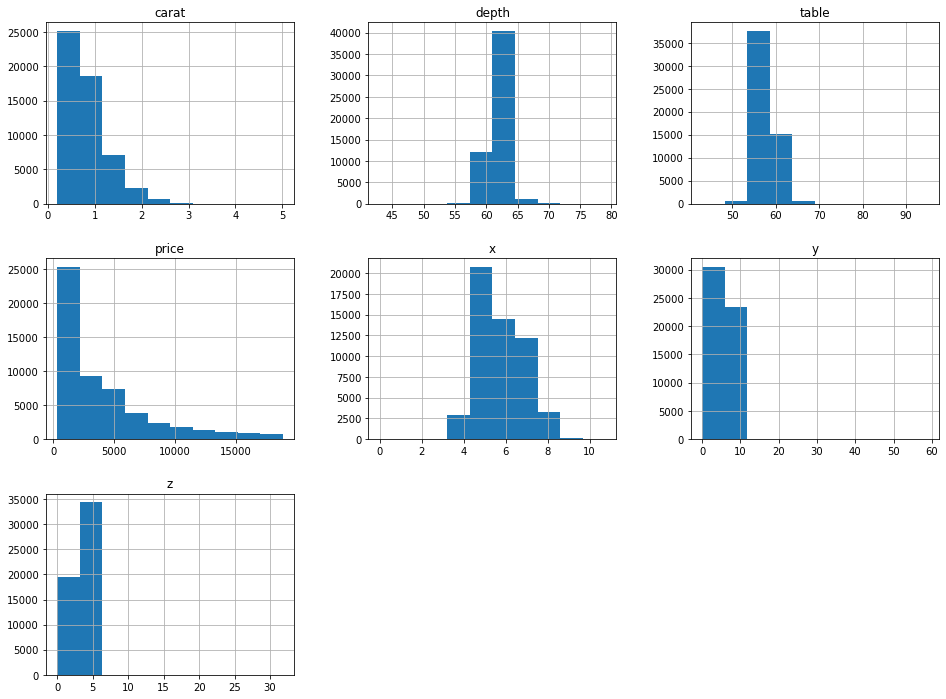

In [852]:
data.hist(figsize=(16, 12))

In [853]:
one_hot = pd.get_dummies(data['color']) #замена категориального признака color
data = data.drop('color',axis = 1)
data = data.join(one_hot)
data  

,carat,cut,clarity,depth,table,price,x,y,z,D,E,F,G,H,I,J
0,0.23,Ideal,SI2,61.5,55.0,326,3.95,3.98,2.43,0,1,0,0,0,0,0
1,0.21,Premium,SI1,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,0
2,0.23,Good,VS1,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,0
3,0.29,Premium,VS2,62.4,58.0,334,4.20,4.23,2.63,0,0,0,0,0,1,0
4,0.31,Good,SI2,63.3,58.0,335,4.34,4.35,2.75,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,SI1,60.8,57.0,2757,5.75,5.76,3.50,1,0,0,0,0,0,0
53936,0.72,Good,SI1,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,0,0,0,0
53937,0.70,Very Good,SI1,62.8,60.0,2757,5.66,5.68,3.56,1,0,0,0,0,0,0
53938,0.86,Premium,SI2,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,0,1,0,0


In [854]:
#Заменяем признак clarity на числовые значения (это не категориальный признак, так как в нём определено отнощение порядка)
mapping = {}

clarity_unique_values = data['clarity'].unique()
for i in range(len(clarity_unique_values)):
    mapping[clarity_unique_values[i]] = i

data = data.replace({'clarity': mapping})
data

,carat,cut,clarity,depth,table,price,x,y,z,D,E,F,G,H,I,J
0,0.23,Ideal,0,61.5,55.0,326,3.95,3.98,2.43,0,1,0,0,0,0,0
1,0.21,Premium,1,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,0
2,0.23,Good,2,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,0
3,0.29,Premium,3,62.4,58.0,334,4.20,4.23,2.63,0,0,0,0,0,1,0
4,0.31,Good,0,63.3,58.0,335,4.34,4.35,2.75,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,1,60.8,57.0,2757,5.75,5.76,3.50,1,0,0,0,0,0,0
53936,0.72,Good,1,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,0,0,0,0
53937,0.70,Very Good,1,62.8,60.0,2757,5.66,5.68,3.56,1,0,0,0,0,0,0
53938,0.86,Premium,0,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,0,1,0,0


array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'clarity'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'G'}>],
       [<AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'J'}>, <AxesSubplot:>]], dtype=object)

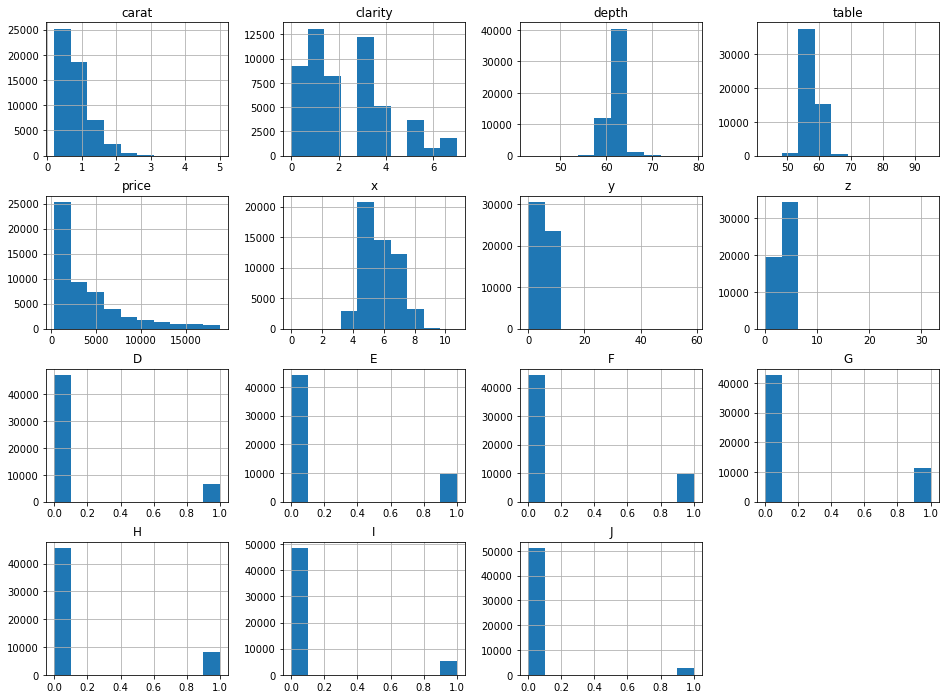

In [855]:
data.hist(figsize=(16, 12))

### Цена, чистота и количество каратов имеют явно распределение, отличающиеся от нормального, поэтому  используем логарифмический преобразователь, чтобы сделать их  нормально распределенными, остальные данные стандартизуем методом z-score

In [856]:
columns_to_log = ["price", "carat", "clarity"]
columns_to_normalize = ["x", "y", "z", "depth", "table", "carat"]

data_to_log = [data[feature] for feature in columns_to_log]
pt = PowerTransformer()
pt.fit(data_to_log)

for i in range(len(columns_to_log)):
    data[columns_to_log[i]] = pt.transform(data_to_log)[i]
    
data

,carat,cut,clarity,depth,table,price,x,y,z,D,E,F,G,H,I,J
0,-0.612675,Ideal,-0.797507,61.5,55.0,1.410182,3.95,3.98,2.43,0,1,0,0,0,0,0
1,-0.915815,Premium,-0.475346,59.8,61.0,1.391161,3.89,3.84,2.31,0,1,0,0,0,0,0
2,-1.024757,Good,-0.331662,56.9,65.0,1.356419,4.05,4.07,2.31,0,1,0,0,0,0,0
3,-1.072454,Premium,-0.262135,62.4,58.0,1.334589,4.20,4.23,2.63,0,0,0,0,0,1,0
4,-0.584426,Good,-0.823060,63.3,58.0,1.407486,4.34,4.35,2.75,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,-0.759439,Ideal,-0.653450,60.8,57.0,1.412889,5.75,5.76,3.50,1,0,0,0,0,0,0
53936,-0.759439,Good,-0.653450,63.1,55.0,1.412889,5.69,5.75,3.61,1,0,0,0,0,0,0
53937,-0.763351,Very Good,-0.649330,62.8,60.0,1.412681,5.66,5.68,3.56,1,0,0,0,0,0,0
53938,-0.502862,Premium,-0.893273,61.0,58.0,1.396135,6.15,6.12,3.74,0,0,0,0,1,0,0


In [857]:
for columns in columns_to_normalize:
    data[columns] = stats.zscore(data[columns])
    
data

,carat,cut,clarity,depth,table,price,x,y,z,D,E,F,G,H,I,J
0,1.122013,Ideal,-0.797507,-0.174092,-1.099672,1.410182,-1.587837,-1.536196,-1.571129,0,1,0,0,0,0,0
1,-0.373175,Premium,-0.475346,-1.360738,1.585529,1.391161,-1.641325,-1.658774,-1.741175,0,1,0,0,0,0,0
2,-0.910517,Good,-0.331662,-3.385019,3.375663,1.356419,-1.498691,-1.457395,-1.741175,0,1,0,0,0,0,0
3,-1.145773,Premium,-0.262135,0.454133,0.242928,1.334589,-1.364971,-1.317305,-1.287720,0,0,0,0,0,1,0
4,1.261344,Good,-0.823060,1.082358,0.242928,1.407486,-1.240167,-1.212238,-1.117674,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.398122,Ideal,-0.653450,-0.662711,-0.204605,1.412889,0.016798,0.022304,-0.054888,1,0,0,0,0,0,0
53936,0.398122,Good,-0.653450,0.942753,-1.099672,1.412889,-0.036690,0.013548,0.100988,1,0,0,0,0,0,0
53937,0.378828,Very Good,-0.649330,0.733344,1.137995,1.412681,-0.063434,-0.047741,0.030135,1,0,0,0,0,0,0
53938,1.663647,Premium,-0.893273,-0.523105,0.242928,1.396135,0.373383,0.337506,0.285204,0,0,0,0,1,0,0


array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'clarity'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'G'}>],
       [<AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'J'}>, <AxesSubplot:>]], dtype=object)

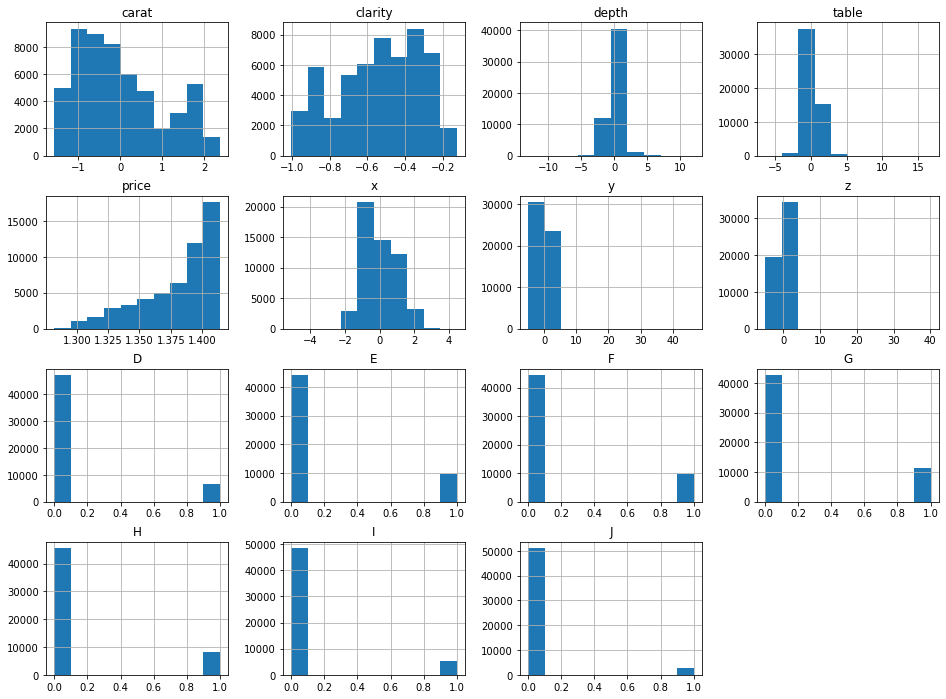

In [858]:
data.hist(figsize=(16, 12))

In [859]:
mapping = {}

clarity_unique_values = data['cut'].unique()
for i in range(len(clarity_unique_values)):
    mapping[clarity_unique_values[i]] = i

data = data.replace({'cut': mapping})
data

,carat,cut,clarity,depth,table,price,x,y,z,D,E,F,G,H,I,J
0,1.122013,0,-0.797507,-0.174092,-1.099672,1.410182,-1.587837,-1.536196,-1.571129,0,1,0,0,0,0,0
1,-0.373175,1,-0.475346,-1.360738,1.585529,1.391161,-1.641325,-1.658774,-1.741175,0,1,0,0,0,0,0
2,-0.910517,2,-0.331662,-3.385019,3.375663,1.356419,-1.498691,-1.457395,-1.741175,0,1,0,0,0,0,0
3,-1.145773,1,-0.262135,0.454133,0.242928,1.334589,-1.364971,-1.317305,-1.287720,0,0,0,0,0,1,0
4,1.261344,2,-0.823060,1.082358,0.242928,1.407486,-1.240167,-1.212238,-1.117674,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.398122,0,-0.653450,-0.662711,-0.204605,1.412889,0.016798,0.022304,-0.054888,1,0,0,0,0,0,0
53936,0.398122,2,-0.653450,0.942753,-1.099672,1.412889,-0.036690,0.013548,0.100988,1,0,0,0,0,0,0
53937,0.378828,3,-0.649330,0.733344,1.137995,1.412681,-0.063434,-0.047741,0.030135,1,0,0,0,0,0,0
53938,1.663647,1,-0.893273,-0.523105,0.242928,1.396135,0.373383,0.337506,0.285204,0,0,0,0,1,0,0


In [860]:
X, y = data.drop("cut", axis=1).to_numpy(), data["cut"].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Обучите 3 модели - обычную, с L1 реализацией, с L2 реализацией и сравните с аналогичными sklearn имплементациями много-классовой логистической регрессии. 

В рамках обучения модели требуется визуализировать:

1) График падания значений ошибки на тренировочной выборке в зависимости от итерации.
2) График падания значений ошибки на валидационной выборке в зависимости от итерации.
3) График роста метрики точности в зависимости от итерации.

<span style="color:red">**Модель считается успешно реализованной, если целевая метрика совпадает с sklearn реализацией. Если разница большая(более 2%), баллы за ДЗ не проставляются.**</span>


#### Обучение обычной модели и сравнение с __LogisticRegression(penalty = 'none', multi_class='multinomial')__ (3 балла)

In [898]:
model = SoftMaxRegression(regularization_type=0.8, lmbd=0, max_iter=200, lr=1)
history_train, history_val, history_accuracy = model.fit(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_test)

baseline_model = LogisticRegression(penalty="none", solver='saga', max_iter=200) 
baseline_model.fit(X_train, y_train)
y_pred_base_model = baseline_model.predict(X_test)
print("Accuracy of SoftMax Regression: {:.2%}".format(history_accuracy[-1]))
print("Accuracy of SKlearn model: {:.2%}".format(np.mean(y_pred_base_model==y_test)))

  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy of SoftMax Regression: 65.92%
Accuracy of SKlearn model: 65.37%


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [893]:
print("Metrics for SoftMax Regression")
print(classification_report(y_test, y_pred))
print("-------------------------------------------------------")
print("Metrics for sklearn model")
print(classification_report(y_test, y_pred_base_model))

Metrics for SoftMax Regression
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      7043
           1       0.67      0.72      0.69      4626
           2       0.57      0.14      0.22      1554
           3       0.51      0.36      0.42      4062
           4       0.84      0.55      0.67       516

    accuracy                           0.66     17801
   macro avg       0.66      0.54      0.56     17801
weighted avg       0.64      0.66      0.63     17801

-------------------------------------------------------
Metrics for sklearn model
              precision    recall  f1-score   support

           0       0.70      0.89      0.79      7043
           1       0.66      0.71      0.68      4626
           2       0.56      0.14      0.22      1554
           3       0.49      0.39      0.44      4062
           4       0.85      0.53      0.65       516

    accuracy                           0.65     17801
   macro avg      

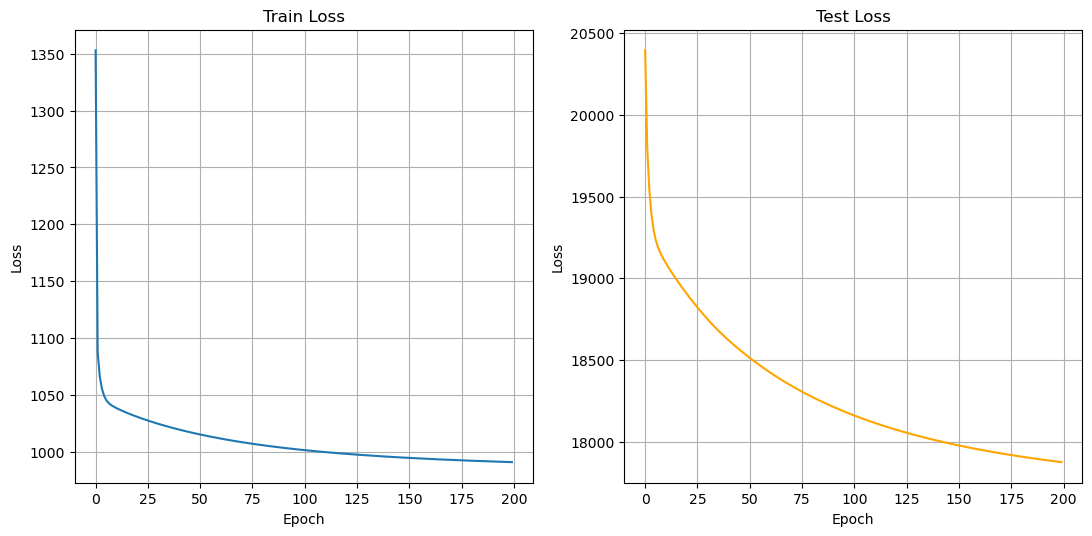

In [894]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(13, 6))
ax1.plot(history_train)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train Loss")
ax1.grid()

ax2.plot(history_val, color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Test Loss")
ax2.grid()
plt.show()

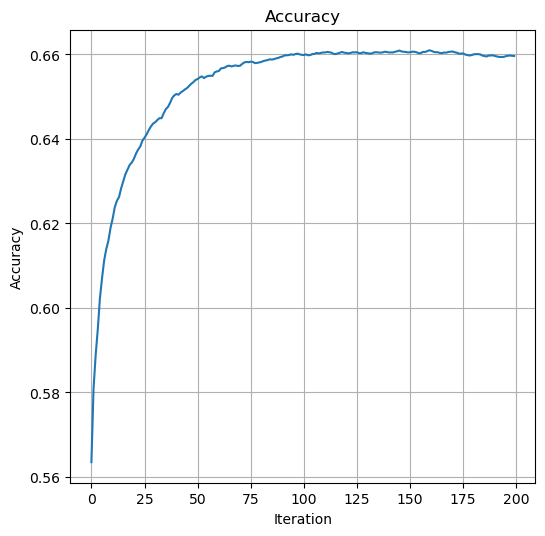

In [895]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(history_accuracy)
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

#### Обучение модели c L1 регуляризацией и сравнение с __LogisticRegression(penalty = 'l1', multi_class='multinomial')__ (3 балла)

In [886]:
my_model = SoftMaxRegression(regularization_type=0, lmbd=1e-4, max_iter=200, lr=1) #L1
history_train_l1, history_val_l1, history_accuracy_l1 = my_model.fit(X_train, y_train, X_test, y_test)
y_pred_l1 = model.predict(X_test)

baseline_model = LogisticRegression(penalty="l1", solver='saga', max_iter=200) 
baseline_model.fit(X_train, y_train)
y_pred_base_model_l1 = baseline_model.predict(X_test)
print("Accuracy of SoftMax Regression: {:.2%}".format(history_accuracy_l1[-1]))
print("Accuracy of SKlearn model: {:.2%}".format(np.mean(y_pred_base_model_l1==y_test)))

  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy of SoftMax Regression: 66.07%
Accuracy of SKlearn model: 65.34%


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


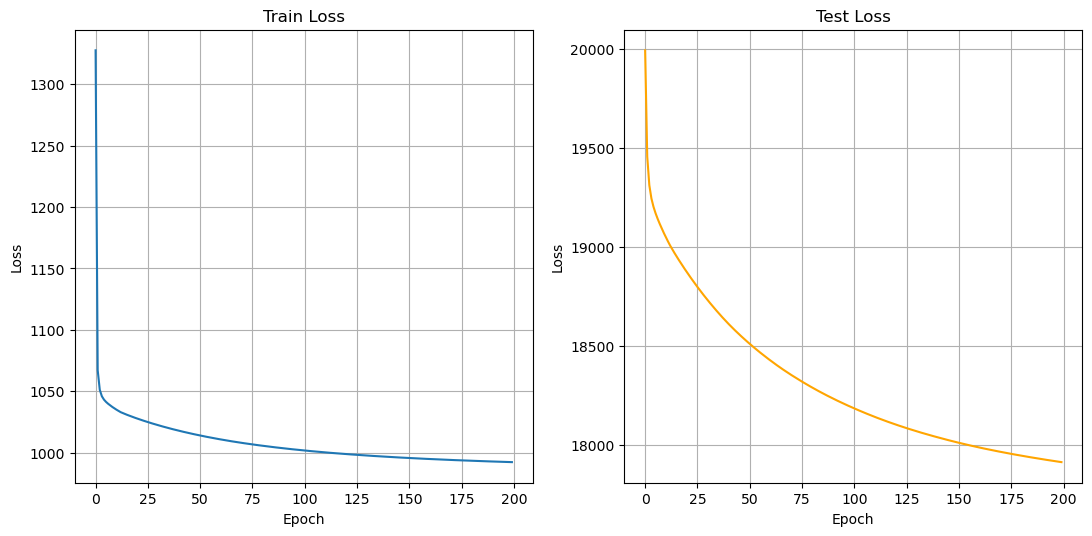

In [887]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(13, 6))
ax1.plot(history_train_l1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train Loss")
ax1.grid()

ax2.plot(history_val_l1, color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Test Loss")
ax2.grid()
plt.show()

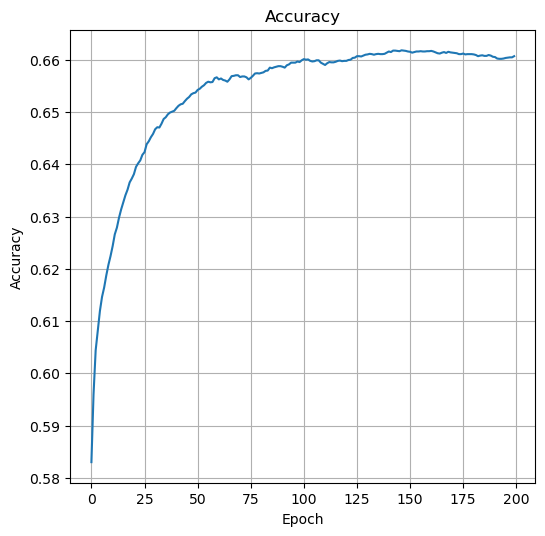

In [888]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(history_accuracy_l1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

#### Обучение модели c L2 регуляризацией и сравнение с __LogisticRegression(penalty = 'l2', multi_class='multinomial')__ (3 балла)

In [889]:
my_model = SoftMaxRegression(regularization_type=1, lmbd=1e-4, max_iter=200, lr=0.9) #L2
history_train_l2, history_val_l2, history_accuracy_l2 = my_model.fit(X_train, y_train, X_test, y_test)
y_pred_l2 = model.predict(X_test)

baseline_model = LogisticRegression(penalty="l2", solver='saga', max_iter=200) 
baseline_model.fit(X_train, y_train)
y_pred_base_model_l2 = baseline_model.predict(X_test)
print("Accuracy of SoftMax Regression: {:.2%}".format(history_accuracy_l2[-1]))
print("Accuracy of SKlearn model: {:.2%}".format(np.mean(y_pred_base_model_l2==y_test)))

  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy of SoftMax Regression: 65.81%
Accuracy of SKlearn model: 65.40%


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


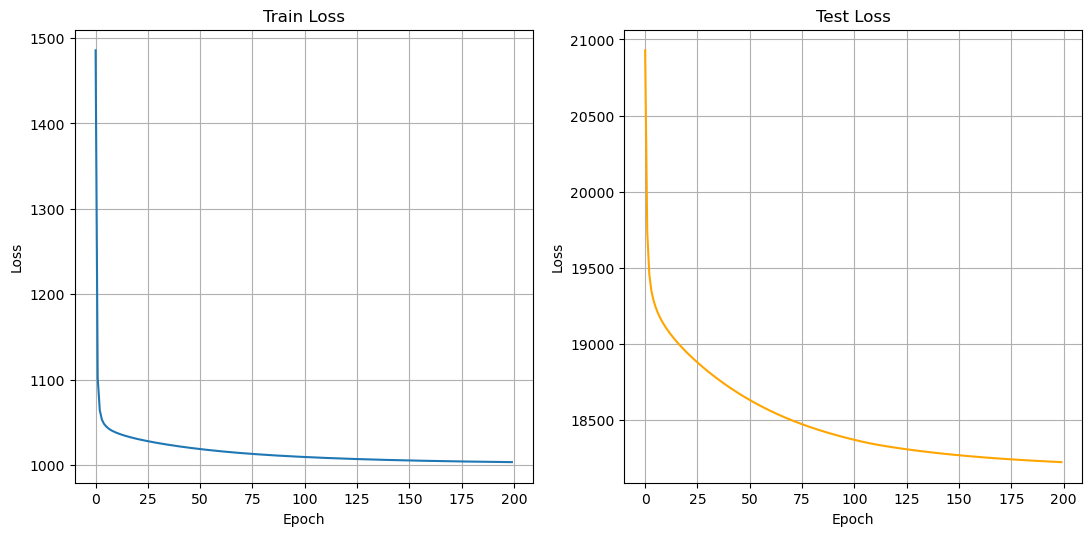

In [890]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(13, 6))
ax1.plot(history_train_l2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train Loss")
ax1.grid()

ax2.plot(history_val_l2, color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Test Loss")
ax2.grid()
plt.show()

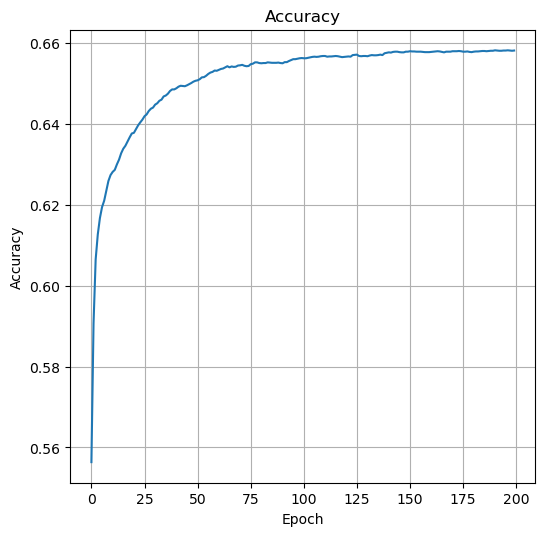

In [891]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(history_accuracy_l2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

#### Видно, что моя модель везде имеет точность лучше, чем у sklearn